### Evaluation code for the dataset Bla bla

To address the intensity scale differences between low-SNR inputs and high-SNR groundtruth images in fluorescence microscopy, we used modified versions of PSNR, SSIM, and MS-SSIM that account for these variations:

MicroSSIM & MicroMS-SSIM: Variants of SSIM and MS-SSIM, where predictions are scaled by an optimal scalar. Both the scaled predictions and groundtruth are then normalized before computing the metrics using the original SSIM or MS-SSIM formulas.

CARE-PSNR: A PSNR variant from CARE [ref], where an optimal scaling factor is applied to the predictions, and PSNR is computed between the scaled predictions and the groundtruth.

### Important ! 

This step has to be executed in order to get predictions!

#### General imports

In [2]:
import os
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

#### Experiments specific imports

In [3]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Download the data

In [5]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={"ht_lif24.zip": None},
)

NOISE_MODELS = pooch.create(
    path="./noise_models",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={
        "nm_ht_lif24_ch1_20ms.npz": None,
        "nm_ht_lif24_ch2_20ms.npz": None,
        "nm_ht_lif24_ch3_20ms.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path="./checkpoints",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={"best.ckpt": None,
              "last.ckpt": None},
)
    

In [ ]:
for i, f in enumerate(NOISE_MODELS.registry):
    NOISE_MODELS.fetch(f"nm_ht_lif24_ch{i+1}_20ms.npz")

DATA.fetch("ht_lif24.zip", processor=pooch.Unzip())

for f in MODEL_CHECKPOINTS.registry:
    MODEL_CHECKPOINTS.fetch(f"{f}")

### Get configs

In [9]:
train_data_config, val_data_config, test_data_configs = get_data_configs(dset_type="20ms")
experiment_params = get_microsplit_parameters(dset_type="20ms", nm_path=NOISE_MODELS.path)

### Create dataset

In [11]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / "ht_lif24.zip.unzip/ht_lif24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24.zip.unzip/ht_lif24/Set1/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set2/uSplit_20ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set3/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set4/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set5/uSplit_20ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set6/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; 

### Get experiment configs

In [12]:
experiment_params["data_stats"] = data_stats  # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# TODO rename to create
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Visualize input data


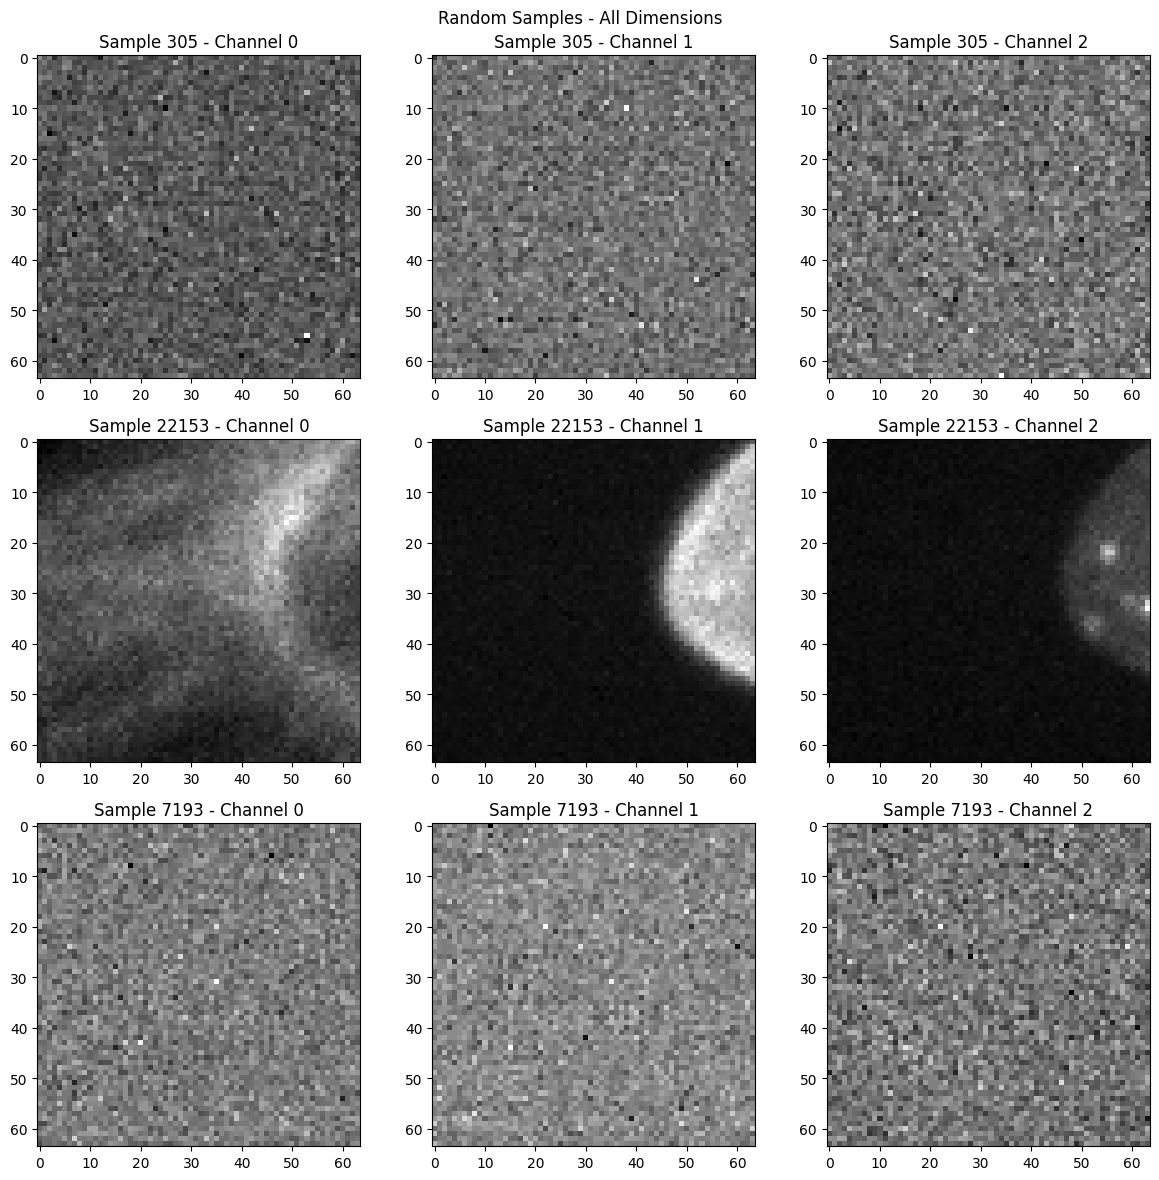

In [13]:
plot_input_patches(dataset=test_dset, num_channels=3, num_samples=3)

### Create model and load checkpoint

In [14]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


#### Set the model to inference mode
(Optional) 
Change the tile size to reduce the appearance of tiling artifacts. The combination of 
# TODO add explanation

In [15]:
model.model.reset_for_inference(tile_size=train_data_config.image_size)

In [16]:
ckpt = load_checkpoint("checkpoints", best=True)
model.load_state_dict(ckpt["state_dict"], strict=True)

Loading checkpoint from: 'checkpoints/best.ckpt' - Epoch: 394


RuntimeError: Error(s) in loading state_dict for VAEModule:
	Missing key(s) in state_dict: "model.first_bottom_up.0.weight", "model.first_bottom_up.0.bias", "model.first_bottom_up.2.res.block.0.weight", "model.first_bottom_up.2.res.block.0.bias", "model.first_bottom_up.2.res.block.0.running_mean", "model.first_bottom_up.2.res.block.0.running_var", "model.first_bottom_up.2.res.block.2.weight", "model.first_bottom_up.2.res.block.2.bias", "model.first_bottom_up.2.res.block.4.weight", "model.first_bottom_up.2.res.block.4.bias", "model.first_bottom_up.2.res.block.4.running_mean", "model.first_bottom_up.2.res.block.4.running_var", "model.first_bottom_up.2.res.block.6.weight", "model.first_bottom_up.2.res.block.6.bias", "model.lowres_first_bottom_ups.0.0.weight", "model.lowres_first_bottom_ups.0.0.bias", "model.lowres_first_bottom_ups.0.2.res.block.0.weight", "model.lowres_first_bottom_ups.0.2.res.block.0.bias", "model.lowres_first_bottom_ups.0.2.res.block.0.running_mean", "model.lowres_first_bottom_ups.0.2.res.block.0.running_var", "model.lowres_first_bottom_ups.0.2.res.block.2.weight", "model.lowres_first_bottom_ups.0.2.res.block.2.bias", "model.lowres_first_bottom_ups.0.2.res.block.4.weight", "model.lowres_first_bottom_ups.0.2.res.block.4.bias", "model.lowres_first_bottom_ups.0.2.res.block.4.running_mean", "model.lowres_first_bottom_ups.0.2.res.block.4.running_var", "model.lowres_first_bottom_ups.0.2.res.block.6.weight", "model.lowres_first_bottom_ups.0.2.res.block.6.bias", "model.lowres_first_bottom_ups.1.0.weight", "model.lowres_first_bottom_ups.1.0.bias", "model.lowres_first_bottom_ups.1.2.res.block.0.weight", "model.lowres_first_bottom_ups.1.2.res.block.0.bias", "model.lowres_first_bottom_ups.1.2.res.block.0.running_mean", "model.lowres_first_bottom_ups.1.2.res.block.0.running_var", "model.lowres_first_bottom_ups.1.2.res.block.2.weight", "model.lowres_first_bottom_ups.1.2.res.block.2.bias", "model.lowres_first_bottom_ups.1.2.res.block.4.weight", "model.lowres_first_bottom_ups.1.2.res.block.4.bias", "model.lowres_first_bottom_ups.1.2.res.block.4.running_mean", "model.lowres_first_bottom_ups.1.2.res.block.4.running_var", "model.lowres_first_bottom_ups.1.2.res.block.6.weight", "model.lowres_first_bottom_ups.1.2.res.block.6.bias", "model.bottom_up_layers.0.net_downsized.0.pre_conv.weight", "model.bottom_up_layers.0.net_downsized.0.pre_conv.bias", "model.bottom_up_layers.0.net_downsized.0.res.block.0.weight", "model.bottom_up_layers.0.net_downsized.0.res.block.0.bias", "model.bottom_up_layers.0.net_downsized.0.res.block.0.running_mean", "model.bottom_up_layers.0.net_downsized.0.res.block.0.running_var", "model.bottom_up_layers.0.net_downsized.0.res.block.2.weight", "model.bottom_up_layers.0.net_downsized.0.res.block.2.bias", "model.bottom_up_layers.0.net_downsized.0.res.block.4.weight", "model.bottom_up_layers.0.net_downsized.0.res.block.4.bias", "model.bottom_up_layers.0.net_downsized.0.res.block.4.running_mean", "model.bottom_up_layers.0.net_downsized.0.res.block.4.running_var", "model.bottom_up_layers.0.net_downsized.0.res.block.6.weight", "model.bottom_up_layers.0.net_downsized.0.res.block.6.bias", "model.bottom_up_layers.0.net_downsized.0.res.block.8.conv.weight", "model.bottom_up_layers.0.net_downsized.0.res.block.8.conv.bias", "model.bottom_up_layers.0.lowres_merge.layer.0.weight", "model.bottom_up_layers.0.lowres_merge.layer.0.bias", "model.bottom_up_layers.0.lowres_merge.layer.1.block.0.weight", "model.bottom_up_layers.0.lowres_merge.layer.1.block.0.bias", "model.bottom_up_layers.0.lowres_merge.layer.1.block.0.running_mean", "model.bottom_up_layers.0.lowres_merge.layer.1.block.0.running_var", "model.bottom_up_layers.0.lowres_merge.layer.1.block.2.weight", "model.bottom_up_layers.0.lowres_merge.layer.1.block.2.bias", "model.bottom_up_layers.0.lowres_merge.layer.1.block.4.weight", "model.bottom_up_layers.0.lowres_merge.layer.1.block.4.bias", "model.bottom_up_layers.0.lowres_merge.layer.1.block.4.running_mean", "model.bottom_up_layers.0.lowres_merge.layer.1.block.4.running_var", "model.bottom_up_layers.0.lowres_merge.layer.1.block.6.weight", "model.bottom_up_layers.0.lowres_merge.layer.1.block.6.bias", "model.bottom_up_layers.0.lowres_merge.layer.1.block.8.conv.weight", "model.bottom_up_layers.0.lowres_merge.layer.1.block.8.conv.bias", "model.bottom_up_layers.1.net_downsized.0.pre_conv.weight", "model.bottom_up_layers.1.net_downsized.0.pre_conv.bias", "model.bottom_up_layers.1.net_downsized.0.res.block.0.weight", "model.bottom_up_layers.1.net_downsized.0.res.block.0.bias", "model.bottom_up_layers.1.net_downsized.0.res.block.0.running_mean", "model.bottom_up_layers.1.net_downsized.0.res.block.0.running_var", "model.bottom_up_layers.1.net_downsized.0.res.block.2.weight", "model.bottom_up_layers.1.net_downsized.0.res.block.2.bias", "model.bottom_up_layers.1.net_downsized.0.res.block.4.weight", "model.bottom_up_layers.1.net_downsized.0.res.block.4.bias", "model.bottom_up_layers.1.net_downsized.0.res.block.4.running_mean", "model.bottom_up_layers.1.net_downsized.0.res.block.4.running_var", "model.bottom_up_layers.1.net_downsized.0.res.block.6.weight", "model.bottom_up_layers.1.net_downsized.0.res.block.6.bias", "model.bottom_up_layers.1.net_downsized.0.res.block.8.conv.weight", "model.bottom_up_layers.1.net_downsized.0.res.block.8.conv.bias", "model.bottom_up_layers.1.lowres_merge.layer.0.weight", "model.bottom_up_layers.1.lowres_merge.layer.0.bias", "model.bottom_up_layers.1.lowres_merge.layer.1.block.0.weight", "model.bottom_up_layers.1.lowres_merge.layer.1.block.0.bias", "model.bottom_up_layers.1.lowres_merge.layer.1.block.0.running_mean", "model.bottom_up_layers.1.lowres_merge.layer.1.block.0.running_var", "model.bottom_up_layers.1.lowres_merge.layer.1.block.2.weight", "model.bottom_up_layers.1.lowres_merge.layer.1.block.2.bias", "model.bottom_up_layers.1.lowres_merge.layer.1.block.4.weight", "model.bottom_up_layers.1.lowres_merge.layer.1.block.4.bias", "model.bottom_up_layers.1.lowres_merge.layer.1.block.4.running_mean", "model.bottom_up_layers.1.lowres_merge.layer.1.block.4.running_var", "model.bottom_up_layers.1.lowres_merge.layer.1.block.6.weight", "model.bottom_up_layers.1.lowres_merge.layer.1.block.6.bias", "model.bottom_up_layers.1.lowres_merge.layer.1.block.8.conv.weight", "model.bottom_up_layers.1.lowres_merge.layer.1.block.8.conv.bias", "model.bottom_up_layers.2.net_downsized.0.pre_conv.weight", "model.bottom_up_layers.2.net_downsized.0.pre_conv.bias", "model.bottom_up_layers.2.net_downsized.0.res.block.0.weight", "model.bottom_up_layers.2.net_downsized.0.res.block.0.bias", "model.bottom_up_layers.2.net_downsized.0.res.block.0.running_mean", "model.bottom_up_layers.2.net_downsized.0.res.block.0.running_var", "model.bottom_up_layers.2.net_downsized.0.res.block.2.weight", "model.bottom_up_layers.2.net_downsized.0.res.block.2.bias", "model.bottom_up_layers.2.net_downsized.0.res.block.4.weight", "model.bottom_up_layers.2.net_downsized.0.res.block.4.bias", "model.bottom_up_layers.2.net_downsized.0.res.block.4.running_mean", "model.bottom_up_layers.2.net_downsized.0.res.block.4.running_var", "model.bottom_up_layers.2.net_downsized.0.res.block.6.weight", "model.bottom_up_layers.2.net_downsized.0.res.block.6.bias", "model.bottom_up_layers.2.net_downsized.0.res.block.8.conv.weight", "model.bottom_up_layers.2.net_downsized.0.res.block.8.conv.bias", "model.bottom_up_layers.2.lowres_merge.layer.0.weight", "model.bottom_up_layers.2.lowres_merge.layer.0.bias", "model.bottom_up_layers.2.lowres_merge.layer.1.block.0.weight", "model.bottom_up_layers.2.lowres_merge.layer.1.block.0.bias", "model.bottom_up_layers.2.lowres_merge.layer.1.block.0.running_mean", "model.bottom_up_layers.2.lowres_merge.layer.1.block.0.running_var", "model.bottom_up_layers.2.lowres_merge.layer.1.block.2.weight", "model.bottom_up_layers.2.lowres_merge.layer.1.block.2.bias", "model.bottom_up_layers.2.lowres_merge.layer.1.block.4.weight", "model.bottom_up_layers.2.lowres_merge.layer.1.block.4.bias", "model.bottom_up_layers.2.lowres_merge.layer.1.block.4.running_mean", "model.bottom_up_layers.2.lowres_merge.layer.1.block.4.running_var", "model.bottom_up_layers.2.lowres_merge.layer.1.block.6.weight", "model.bottom_up_layers.2.lowres_merge.layer.1.block.6.bias", "model.bottom_up_layers.2.lowres_merge.layer.1.block.8.conv.weight", "model.bottom_up_layers.2.lowres_merge.layer.1.block.8.conv.bias", "model.bottom_up_layers.3.net_downsized.0.pre_conv.weight", "model.bottom_up_layers.3.net_downsized.0.pre_conv.bias", "model.bottom_up_layers.3.net_downsized.0.res.block.0.weight", "model.bottom_up_layers.3.net_downsized.0.res.block.0.bias", "model.bottom_up_layers.3.net_downsized.0.res.block.0.running_mean", "model.bottom_up_layers.3.net_downsized.0.res.block.0.running_var", "model.bottom_up_layers.3.net_downsized.0.res.block.2.weight", "model.bottom_up_layers.3.net_downsized.0.res.block.2.bias", "model.bottom_up_layers.3.net_downsized.0.res.block.4.weight", "model.bottom_up_layers.3.net_downsized.0.res.block.4.bias", "model.bottom_up_layers.3.net_downsized.0.res.block.4.running_mean", "model.bottom_up_layers.3.net_downsized.0.res.block.4.running_var", "model.bottom_up_layers.3.net_downsized.0.res.block.6.weight", "model.bottom_up_layers.3.net_downsized.0.res.block.6.bias", "model.bottom_up_layers.3.net_downsized.0.res.block.8.conv.weight", "model.bottom_up_layers.3.net_downsized.0.res.block.8.conv.bias", "model.bottom_up_layers.3.lowres_merge.layer.0.weight", "model.bottom_up_layers.3.lowres_merge.layer.0.bias", "model.bottom_up_layers.3.lowres_merge.layer.1.block.0.weight", "model.bottom_up_layers.3.lowres_merge.layer.1.block.0.bias", "model.bottom_up_layers.3.lowres_merge.layer.1.block.0.running_mean", "model.bottom_up_layers.3.lowres_merge.layer.1.block.0.running_var", "model.bottom_up_layers.3.lowres_merge.layer.1.block.2.weight", "model.bottom_up_layers.3.lowres_merge.layer.1.block.2.bias", "model.bottom_up_layers.3.lowres_merge.layer.1.block.4.weight", "model.bottom_up_layers.3.lowres_merge.layer.1.block.4.bias", "model.bottom_up_layers.3.lowres_merge.layer.1.block.4.running_mean", "model.bottom_up_layers.3.lowres_merge.layer.1.block.4.running_var", "model.bottom_up_layers.3.lowres_merge.layer.1.block.6.weight", "model.bottom_up_layers.3.lowres_merge.layer.1.block.6.bias", "model.bottom_up_layers.3.lowres_merge.layer.1.block.8.conv.weight", "model.bottom_up_layers.3.lowres_merge.layer.1.block.8.conv.bias", "model.top_down_layers.0.deterministic_block.0.pre_conv.weight", "model.top_down_layers.0.deterministic_block.0.pre_conv.bias", "model.top_down_layers.0.deterministic_block.0.res.block.0.weight", "model.top_down_layers.0.deterministic_block.0.res.block.0.bias", "model.top_down_layers.0.deterministic_block.0.res.block.0.running_mean", "model.top_down_layers.0.deterministic_block.0.res.block.0.running_var", "model.top_down_layers.0.deterministic_block.0.res.block.2.weight", "model.top_down_layers.0.deterministic_block.0.res.block.2.bias", "model.top_down_layers.0.deterministic_block.0.res.block.4.weight", "model.top_down_layers.0.deterministic_block.0.res.block.4.bias", "model.top_down_layers.0.deterministic_block.0.res.block.4.running_mean", "model.top_down_layers.0.deterministic_block.0.res.block.4.running_var", "model.top_down_layers.0.deterministic_block.0.res.block.6.weight", "model.top_down_layers.0.deterministic_block.0.res.block.6.bias", "model.top_down_layers.0.deterministic_block.0.res.block.8.conv.weight", "model.top_down_layers.0.deterministic_block.0.res.block.8.conv.bias", "model.top_down_layers.0.stochastic.conv_in_p.weight", "model.top_down_layers.0.stochastic.conv_in_p.bias", "model.top_down_layers.0.stochastic.conv_in_q.weight", "model.top_down_layers.0.stochastic.conv_in_q.bias", "model.top_down_layers.0.stochastic.conv_out.weight", "model.top_down_layers.0.stochastic.conv_out.bias", "model.top_down_layers.0.merge.layer.0.weight", "model.top_down_layers.0.merge.layer.0.bias", "model.top_down_layers.0.merge.layer.1.block.0.weight", "model.top_down_layers.0.merge.layer.1.block.0.bias", "model.top_down_layers.0.merge.layer.1.block.0.running_mean", "model.top_down_layers.0.merge.layer.1.block.0.running_var", "model.top_down_layers.0.merge.layer.1.block.2.weight", "model.top_down_layers.0.merge.layer.1.block.2.bias", "model.top_down_layers.0.merge.layer.1.block.4.weight", "model.top_down_layers.0.merge.layer.1.block.4.bias", "model.top_down_layers.0.merge.layer.1.block.4.running_mean", "model.top_down_layers.0.merge.layer.1.block.4.running_var", "model.top_down_layers.0.merge.layer.1.block.6.weight", "model.top_down_layers.0.merge.layer.1.block.6.bias", "model.top_down_layers.0.merge.layer.1.block.8.conv.weight", "model.top_down_layers.0.merge.layer.1.block.8.conv.bias", "model.top_down_layers.0.skip_connection_merger.layer.0.weight", "model.top_down_layers.0.skip_connection_merger.layer.0.bias", "model.top_down_layers.0.skip_connection_merger.layer.1.block.0.weight", "model.top_down_layers.0.skip_connection_merger.layer.1.block.0.bias", "model.top_down_layers.0.skip_connection_merger.layer.1.block.0.running_mean", "model.top_down_layers.0.skip_connection_merger.layer.1.block.0.running_var", "model.top_down_layers.0.skip_connection_merger.layer.1.block.2.weight", "model.top_down_layers.0.skip_connection_merger.layer.1.block.2.bias", "model.top_down_layers.0.skip_connection_merger.layer.1.block.4.weight", "model.top_down_layers.0.skip_connection_merger.layer.1.block.4.bias", "model.top_down_layers.0.skip_connection_merger.layer.1.block.4.running_mean", "model.top_down_layers.0.skip_connection_merger.layer.1.block.4.running_var", "model.top_down_layers.0.skip_connection_merger.layer.1.block.6.weight", "model.top_down_layers.0.skip_connection_merger.layer.1.block.6.bias", "model.top_down_layers.0.skip_connection_merger.layer.1.block.8.conv.weight", "model.top_down_layers.0.skip_connection_merger.layer.1.block.8.conv.bias", "model.top_down_layers.1.deterministic_block.0.pre_conv.weight", "model.top_down_layers.1.deterministic_block.0.pre_conv.bias", "model.top_down_layers.1.deterministic_block.0.res.block.0.weight", "model.top_down_layers.1.deterministic_block.0.res.block.0.bias", "model.top_down_layers.1.deterministic_block.0.res.block.0.running_mean", "model.top_down_layers.1.deterministic_block.0.res.block.0.running_var", "model.top_down_layers.1.deterministic_block.0.res.block.2.weight", "model.top_down_layers.1.deterministic_block.0.res.block.2.bias", "model.top_down_layers.1.deterministic_block.0.res.block.4.weight", "model.top_down_layers.1.deterministic_block.0.res.block.4.bias", "model.top_down_layers.1.deterministic_block.0.res.block.4.running_mean", "model.top_down_layers.1.deterministic_block.0.res.block.4.running_var", "model.top_down_layers.1.deterministic_block.0.res.block.6.weight", "model.top_down_layers.1.deterministic_block.0.res.block.6.bias", "model.top_down_layers.1.deterministic_block.0.res.block.8.conv.weight", "model.top_down_layers.1.deterministic_block.0.res.block.8.conv.bias", "model.top_down_layers.1.stochastic.conv_in_p.weight", "model.top_down_layers.1.stochastic.conv_in_p.bias", "model.top_down_layers.1.stochastic.conv_in_q.weight", "model.top_down_layers.1.stochastic.conv_in_q.bias", "model.top_down_layers.1.stochastic.conv_out.weight", "model.top_down_layers.1.stochastic.conv_out.bias", "model.top_down_layers.1.merge.layer.0.weight", "model.top_down_layers.1.merge.layer.0.bias", "model.top_down_layers.1.merge.layer.1.block.0.weight", "model.top_down_layers.1.merge.layer.1.block.0.bias", "model.top_down_layers.1.merge.layer.1.block.0.running_mean", "model.top_down_layers.1.merge.layer.1.block.0.running_var", "model.top_down_layers.1.merge.layer.1.block.2.weight", "model.top_down_layers.1.merge.layer.1.block.2.bias", "model.top_down_layers.1.merge.layer.1.block.4.weight", "model.top_down_layers.1.merge.layer.1.block.4.bias", "model.top_down_layers.1.merge.layer.1.block.4.running_mean", "model.top_down_layers.1.merge.layer.1.block.4.running_var", "model.top_down_layers.1.merge.layer.1.block.6.weight", "model.top_down_layers.1.merge.layer.1.block.6.bias", "model.top_down_layers.1.merge.layer.1.block.8.conv.weight", "model.top_down_layers.1.merge.layer.1.block.8.conv.bias", "model.top_down_layers.1.skip_connection_merger.layer.0.weight", "model.top_down_layers.1.skip_connection_merger.layer.0.bias", "model.top_down_layers.1.skip_connection_merger.layer.1.block.0.weight", "model.top_down_layers.1.skip_connection_merger.layer.1.block.0.bias", "model.top_down_layers.1.skip_connection_merger.layer.1.block.0.running_mean", "model.top_down_layers.1.skip_connection_merger.layer.1.block.0.running_var", "model.top_down_layers.1.skip_connection_merger.layer.1.block.2.weight", "model.top_down_layers.1.skip_connection_merger.layer.1.block.2.bias", "model.top_down_layers.1.skip_connection_merger.layer.1.block.4.weight", "model.top_down_layers.1.skip_connection_merger.layer.1.block.4.bias", "model.top_down_layers.1.skip_connection_merger.layer.1.block.4.running_mean", "model.top_down_layers.1.skip_connection_merger.layer.1.block.4.running_var", "model.top_down_layers.1.skip_connection_merger.layer.1.block.6.weight", "model.top_down_layers.1.skip_connection_merger.layer.1.block.6.bias", "model.top_down_layers.1.skip_connection_merger.layer.1.block.8.conv.weight", "model.top_down_layers.1.skip_connection_merger.layer.1.block.8.conv.bias", "model.top_down_layers.2.deterministic_block.0.pre_conv.weight", "model.top_down_layers.2.deterministic_block.0.pre_conv.bias", "model.top_down_layers.2.deterministic_block.0.res.block.0.weight", "model.top_down_layers.2.deterministic_block.0.res.block.0.bias", "model.top_down_layers.2.deterministic_block.0.res.block.0.running_mean", "model.top_down_layers.2.deterministic_block.0.res.block.0.running_var", "model.top_down_layers.2.deterministic_block.0.res.block.2.weight", "model.top_down_layers.2.deterministic_block.0.res.block.2.bias", "model.top_down_layers.2.deterministic_block.0.res.block.4.weight", "model.top_down_layers.2.deterministic_block.0.res.block.4.bias", "model.top_down_layers.2.deterministic_block.0.res.block.4.running_mean", "model.top_down_layers.2.deterministic_block.0.res.block.4.running_var", "model.top_down_layers.2.deterministic_block.0.res.block.6.weight", "model.top_down_layers.2.deterministic_block.0.res.block.6.bias", "model.top_down_layers.2.deterministic_block.0.res.block.8.conv.weight", "model.top_down_layers.2.deterministic_block.0.res.block.8.conv.bias", "model.top_down_layers.2.stochastic.conv_in_p.weight", "model.top_down_layers.2.stochastic.conv_in_p.bias", "model.top_down_layers.2.stochastic.conv_in_q.weight", "model.top_down_layers.2.stochastic.conv_in_q.bias", "model.top_down_layers.2.stochastic.conv_out.weight", "model.top_down_layers.2.stochastic.conv_out.bias", "model.top_down_layers.2.merge.layer.0.weight", "model.top_down_layers.2.merge.layer.0.bias", "model.top_down_layers.2.merge.layer.1.block.0.weight", "model.top_down_layers.2.merge.layer.1.block.0.bias", "model.top_down_layers.2.merge.layer.1.block.0.running_mean", "model.top_down_layers.2.merge.layer.1.block.0.running_var", "model.top_down_layers.2.merge.layer.1.block.2.weight", "model.top_down_layers.2.merge.layer.1.block.2.bias", "model.top_down_layers.2.merge.layer.1.block.4.weight", "model.top_down_layers.2.merge.layer.1.block.4.bias", "model.top_down_layers.2.merge.layer.1.block.4.running_mean", "model.top_down_layers.2.merge.layer.1.block.4.running_var", "model.top_down_layers.2.merge.layer.1.block.6.weight", "model.top_down_layers.2.merge.layer.1.block.6.bias", "model.top_down_layers.2.merge.layer.1.block.8.conv.weight", "model.top_down_layers.2.merge.layer.1.block.8.conv.bias", "model.top_down_layers.2.skip_connection_merger.layer.0.weight", "model.top_down_layers.2.skip_connection_merger.layer.0.bias", "model.top_down_layers.2.skip_connection_merger.layer.1.block.0.weight", "model.top_down_layers.2.skip_connection_merger.layer.1.block.0.bias", "model.top_down_layers.2.skip_connection_merger.layer.1.block.0.running_mean", "model.top_down_layers.2.skip_connection_merger.layer.1.block.0.running_var", "model.top_down_layers.2.skip_connection_merger.layer.1.block.2.weight", "model.top_down_layers.2.skip_connection_merger.layer.1.block.2.bias", "model.top_down_layers.2.skip_connection_merger.layer.1.block.4.weight", "model.top_down_layers.2.skip_connection_merger.layer.1.block.4.bias", "model.top_down_layers.2.skip_connection_merger.layer.1.block.4.running_mean", "model.top_down_layers.2.skip_connection_merger.layer.1.block.4.running_var", "model.top_down_layers.2.skip_connection_merger.layer.1.block.6.weight", "model.top_down_layers.2.skip_connection_merger.layer.1.block.6.bias", "model.top_down_layers.2.skip_connection_merger.layer.1.block.8.conv.weight", "model.top_down_layers.2.skip_connection_merger.layer.1.block.8.conv.bias", "model.top_down_layers.3.top_prior_params", "model.top_down_layers.3.deterministic_block.0.pre_conv.weight", "model.top_down_layers.3.deterministic_block.0.pre_conv.bias", "model.top_down_layers.3.deterministic_block.0.res.block.0.weight", "model.top_down_layers.3.deterministic_block.0.res.block.0.bias", "model.top_down_layers.3.deterministic_block.0.res.block.0.running_mean", "model.top_down_layers.3.deterministic_block.0.res.block.0.running_var", "model.top_down_layers.3.deterministic_block.0.res.block.2.weight", "model.top_down_layers.3.deterministic_block.0.res.block.2.bias", "model.top_down_layers.3.deterministic_block.0.res.block.4.weight", "model.top_down_layers.3.deterministic_block.0.res.block.4.bias", "model.top_down_layers.3.deterministic_block.0.res.block.4.running_mean", "model.top_down_layers.3.deterministic_block.0.res.block.4.running_var", "model.top_down_layers.3.deterministic_block.0.res.block.6.weight", "model.top_down_layers.3.deterministic_block.0.res.block.6.bias", "model.top_down_layers.3.deterministic_block.0.res.block.8.conv.weight", "model.top_down_layers.3.deterministic_block.0.res.block.8.conv.bias", "model.top_down_layers.3.stochastic.conv_in_q.weight", "model.top_down_layers.3.stochastic.conv_in_q.bias", "model.top_down_layers.3.stochastic.conv_out.weight", "model.top_down_layers.3.stochastic.conv_out.bias", "model.final_top_down.0.res.block.0.weight", "model.final_top_down.0.res.block.0.bias", "model.final_top_down.0.res.block.0.running_mean", "model.final_top_down.0.res.block.0.running_var", "model.final_top_down.0.res.block.2.weight", "model.final_top_down.0.res.block.2.bias", "model.final_top_down.0.res.block.4.weight", "model.final_top_down.0.res.block.4.bias", "model.final_top_down.0.res.block.4.running_mean", "model.final_top_down.0.res.block.4.running_var", "model.final_top_down.0.res.block.6.weight", "model.final_top_down.0.res.block.6.bias", "model.final_top_down.0.res.block.8.conv.weight", "model.final_top_down.0.res.block.8.conv.bias", "model.output_layer.weight", "model.output_layer.bias", "model.parameter_net.weight", "model.parameter_net.bias". 
	Unexpected key(s) in state_dict: "noiseModel.nmodel_0.weight", "noiseModel.nmodel_1.weight", "noiseModel.nmodel_2.weight", "first_bottom_up.0.weight", "first_bottom_up.0.bias", "first_bottom_up.2.res.block.0.weight", "first_bottom_up.2.res.block.0.bias", "first_bottom_up.2.res.block.0.running_mean", "first_bottom_up.2.res.block.0.running_var", "first_bottom_up.2.res.block.0.num_batches_tracked", "first_bottom_up.2.res.block.2.weight", "first_bottom_up.2.res.block.2.bias", "first_bottom_up.2.res.block.4.weight", "first_bottom_up.2.res.block.4.bias", "first_bottom_up.2.res.block.4.running_mean", "first_bottom_up.2.res.block.4.running_var", "first_bottom_up.2.res.block.4.num_batches_tracked", "first_bottom_up.2.res.block.6.weight", "first_bottom_up.2.res.block.6.bias", "lowres_first_bottom_ups.0.0.weight", "lowres_first_bottom_ups.0.0.bias", "lowres_first_bottom_ups.0.2.res.block.0.weight", "lowres_first_bottom_ups.0.2.res.block.0.bias", "lowres_first_bottom_ups.0.2.res.block.0.running_mean", "lowres_first_bottom_ups.0.2.res.block.0.running_var", "lowres_first_bottom_ups.0.2.res.block.0.num_batches_tracked", "lowres_first_bottom_ups.0.2.res.block.2.weight", "lowres_first_bottom_ups.0.2.res.block.2.bias", "lowres_first_bottom_ups.0.2.res.block.4.weight", "lowres_first_bottom_ups.0.2.res.block.4.bias", "lowres_first_bottom_ups.0.2.res.block.4.running_mean", "lowres_first_bottom_ups.0.2.res.block.4.running_var", "lowres_first_bottom_ups.0.2.res.block.4.num_batches_tracked", "lowres_first_bottom_ups.0.2.res.block.6.weight", "lowres_first_bottom_ups.0.2.res.block.6.bias", "lowres_first_bottom_ups.1.0.weight", "lowres_first_bottom_ups.1.0.bias", "lowres_first_bottom_ups.1.2.res.block.0.weight", "lowres_first_bottom_ups.1.2.res.block.0.bias", "lowres_first_bottom_ups.1.2.res.block.0.running_mean", "lowres_first_bottom_ups.1.2.res.block.0.running_var", "lowres_first_bottom_ups.1.2.res.block.0.num_batches_tracked", "lowres_first_bottom_ups.1.2.res.block.2.weight", "lowres_first_bottom_ups.1.2.res.block.2.bias", "lowres_first_bottom_ups.1.2.res.block.4.weight", "lowres_first_bottom_ups.1.2.res.block.4.bias", "lowres_first_bottom_ups.1.2.res.block.4.running_mean", "lowres_first_bottom_ups.1.2.res.block.4.running_var", "lowres_first_bottom_ups.1.2.res.block.4.num_batches_tracked", "lowres_first_bottom_ups.1.2.res.block.6.weight", "lowres_first_bottom_ups.1.2.res.block.6.bias", "bottom_up_layers.0.net_downsized.0.pre_conv.weight", "bottom_up_layers.0.net_downsized.0.pre_conv.bias", "bottom_up_layers.0.net_downsized.0.res.block.0.weight", "bottom_up_layers.0.net_downsized.0.res.block.0.bias", "bottom_up_layers.0.net_downsized.0.res.block.0.running_mean", "bottom_up_layers.0.net_downsized.0.res.block.0.running_var", "bottom_up_layers.0.net_downsized.0.res.block.0.num_batches_tracked", "bottom_up_layers.0.net_downsized.0.res.block.2.weight", "bottom_up_layers.0.net_downsized.0.res.block.2.bias", "bottom_up_layers.0.net_downsized.0.res.block.4.weight", "bottom_up_layers.0.net_downsized.0.res.block.4.bias", "bottom_up_layers.0.net_downsized.0.res.block.4.running_mean", "bottom_up_layers.0.net_downsized.0.res.block.4.running_var", "bottom_up_layers.0.net_downsized.0.res.block.4.num_batches_tracked", "bottom_up_layers.0.net_downsized.0.res.block.6.weight", "bottom_up_layers.0.net_downsized.0.res.block.6.bias", "bottom_up_layers.0.net_downsized.0.res.block.8.conv.weight", "bottom_up_layers.0.net_downsized.0.res.block.8.conv.bias", "bottom_up_layers.0.lowres_merge.layer.0.weight", "bottom_up_layers.0.lowres_merge.layer.0.bias", "bottom_up_layers.0.lowres_merge.layer.1.block.0.weight", "bottom_up_layers.0.lowres_merge.layer.1.block.0.bias", "bottom_up_layers.0.lowres_merge.layer.1.block.0.running_mean", "bottom_up_layers.0.lowres_merge.layer.1.block.0.running_var", "bottom_up_layers.0.lowres_merge.layer.1.block.0.num_batches_tracked", "bottom_up_layers.0.lowres_merge.layer.1.block.2.weight", "bottom_up_layers.0.lowres_merge.layer.1.block.2.bias", "bottom_up_layers.0.lowres_merge.layer.1.block.4.weight", "bottom_up_layers.0.lowres_merge.layer.1.block.4.bias", "bottom_up_layers.0.lowres_merge.layer.1.block.4.running_mean", "bottom_up_layers.0.lowres_merge.layer.1.block.4.running_var", "bottom_up_layers.0.lowres_merge.layer.1.block.4.num_batches_tracked", "bottom_up_layers.0.lowres_merge.layer.1.block.6.weight", "bottom_up_layers.0.lowres_merge.layer.1.block.6.bias", "bottom_up_layers.0.lowres_merge.layer.1.block.8.conv.weight", "bottom_up_layers.0.lowres_merge.layer.1.block.8.conv.bias", "bottom_up_layers.1.net_downsized.0.pre_conv.weight", "bottom_up_layers.1.net_downsized.0.pre_conv.bias", "bottom_up_layers.1.net_downsized.0.res.block.0.weight", "bottom_up_layers.1.net_downsized.0.res.block.0.bias", "bottom_up_layers.1.net_downsized.0.res.block.0.running_mean", "bottom_up_layers.1.net_downsized.0.res.block.0.running_var", "bottom_up_layers.1.net_downsized.0.res.block.0.num_batches_tracked", "bottom_up_layers.1.net_downsized.0.res.block.2.weight", "bottom_up_layers.1.net_downsized.0.res.block.2.bias", "bottom_up_layers.1.net_downsized.0.res.block.4.weight", "bottom_up_layers.1.net_downsized.0.res.block.4.bias", "bottom_up_layers.1.net_downsized.0.res.block.4.running_mean", "bottom_up_layers.1.net_downsized.0.res.block.4.running_var", "bottom_up_layers.1.net_downsized.0.res.block.4.num_batches_tracked", "bottom_up_layers.1.net_downsized.0.res.block.6.weight", "bottom_up_layers.1.net_downsized.0.res.block.6.bias", "bottom_up_layers.1.net_downsized.0.res.block.8.conv.weight", "bottom_up_layers.1.net_downsized.0.res.block.8.conv.bias", "bottom_up_layers.1.lowres_merge.layer.0.weight", "bottom_up_layers.1.lowres_merge.layer.0.bias", "bottom_up_layers.1.lowres_merge.layer.1.block.0.weight", "bottom_up_layers.1.lowres_merge.layer.1.block.0.bias", "bottom_up_layers.1.lowres_merge.layer.1.block.0.running_mean", "bottom_up_layers.1.lowres_merge.layer.1.block.0.running_var", "bottom_up_layers.1.lowres_merge.layer.1.block.0.num_batches_tracked", "bottom_up_layers.1.lowres_merge.layer.1.block.2.weight", "bottom_up_layers.1.lowres_merge.layer.1.block.2.bias", "bottom_up_layers.1.lowres_merge.layer.1.block.4.weight", "bottom_up_layers.1.lowres_merge.layer.1.block.4.bias", "bottom_up_layers.1.lowres_merge.layer.1.block.4.running_mean", "bottom_up_layers.1.lowres_merge.layer.1.block.4.running_var", "bottom_up_layers.1.lowres_merge.layer.1.block.4.num_batches_tracked", "bottom_up_layers.1.lowres_merge.layer.1.block.6.weight", "bottom_up_layers.1.lowres_merge.layer.1.block.6.bias", "bottom_up_layers.1.lowres_merge.layer.1.block.8.conv.weight", "bottom_up_layers.1.lowres_merge.layer.1.block.8.conv.bias", "bottom_up_layers.2.net_downsized.0.pre_conv.weight", "bottom_up_layers.2.net_downsized.0.pre_conv.bias", "bottom_up_layers.2.net_downsized.0.res.block.0.weight", "bottom_up_layers.2.net_downsized.0.res.block.0.bias", "bottom_up_layers.2.net_downsized.0.res.block.0.running_mean", "bottom_up_layers.2.net_downsized.0.res.block.0.running_var", "bottom_up_layers.2.net_downsized.0.res.block.0.num_batches_tracked", "bottom_up_layers.2.net_downsized.0.res.block.2.weight", "bottom_up_layers.2.net_downsized.0.res.block.2.bias", "bottom_up_layers.2.net_downsized.0.res.block.4.weight", "bottom_up_layers.2.net_downsized.0.res.block.4.bias", "bottom_up_layers.2.net_downsized.0.res.block.4.running_mean", "bottom_up_layers.2.net_downsized.0.res.block.4.running_var", "bottom_up_layers.2.net_downsized.0.res.block.4.num_batches_tracked", "bottom_up_layers.2.net_downsized.0.res.block.6.weight", "bottom_up_layers.2.net_downsized.0.res.block.6.bias", "bottom_up_layers.2.net_downsized.0.res.block.8.conv.weight", "bottom_up_layers.2.net_downsized.0.res.block.8.conv.bias", "bottom_up_layers.2.lowres_merge.layer.0.weight", "bottom_up_layers.2.lowres_merge.layer.0.bias", "bottom_up_layers.2.lowres_merge.layer.1.block.0.weight", "bottom_up_layers.2.lowres_merge.layer.1.block.0.bias", "bottom_up_layers.2.lowres_merge.layer.1.block.0.running_mean", "bottom_up_layers.2.lowres_merge.layer.1.block.0.running_var", "bottom_up_layers.2.lowres_merge.layer.1.block.0.num_batches_tracked", "bottom_up_layers.2.lowres_merge.layer.1.block.2.weight", "bottom_up_layers.2.lowres_merge.layer.1.block.2.bias", "bottom_up_layers.2.lowres_merge.layer.1.block.4.weight", "bottom_up_layers.2.lowres_merge.layer.1.block.4.bias", "bottom_up_layers.2.lowres_merge.layer.1.block.4.running_mean", "bottom_up_layers.2.lowres_merge.layer.1.block.4.running_var", "bottom_up_layers.2.lowres_merge.layer.1.block.4.num_batches_tracked", "bottom_up_layers.2.lowres_merge.layer.1.block.6.weight", "bottom_up_layers.2.lowres_merge.layer.1.block.6.bias", "bottom_up_layers.2.lowres_merge.layer.1.block.8.conv.weight", "bottom_up_layers.2.lowres_merge.layer.1.block.8.conv.bias", "bottom_up_layers.3.net_downsized.0.pre_conv.weight", "bottom_up_layers.3.net_downsized.0.pre_conv.bias", "bottom_up_layers.3.net_downsized.0.res.block.0.weight", "bottom_up_layers.3.net_downsized.0.res.block.0.bias", "bottom_up_layers.3.net_downsized.0.res.block.0.running_mean", "bottom_up_layers.3.net_downsized.0.res.block.0.running_var", "bottom_up_layers.3.net_downsized.0.res.block.0.num_batches_tracked", "bottom_up_layers.3.net_downsized.0.res.block.2.weight", "bottom_up_layers.3.net_downsized.0.res.block.2.bias", "bottom_up_layers.3.net_downsized.0.res.block.4.weight", "bottom_up_layers.3.net_downsized.0.res.block.4.bias", "bottom_up_layers.3.net_downsized.0.res.block.4.running_mean", "bottom_up_layers.3.net_downsized.0.res.block.4.running_var", "bottom_up_layers.3.net_downsized.0.res.block.4.num_batches_tracked", "bottom_up_layers.3.net_downsized.0.res.block.6.weight", "bottom_up_layers.3.net_downsized.0.res.block.6.bias", "bottom_up_layers.3.net_downsized.0.res.block.8.conv.weight", "bottom_up_layers.3.net_downsized.0.res.block.8.conv.bias", "bottom_up_layers.3.lowres_merge.layer.0.weight", "bottom_up_layers.3.lowres_merge.layer.0.bias", "bottom_up_layers.3.lowres_merge.layer.1.block.0.weight", "bottom_up_layers.3.lowres_merge.layer.1.block.0.bias", "bottom_up_layers.3.lowres_merge.layer.1.block.0.running_mean", "bottom_up_layers.3.lowres_merge.layer.1.block.0.running_var", "bottom_up_layers.3.lowres_merge.layer.1.block.0.num_batches_tracked", "bottom_up_layers.3.lowres_merge.layer.1.block.2.weight", "bottom_up_layers.3.lowres_merge.layer.1.block.2.bias", "bottom_up_layers.3.lowres_merge.layer.1.block.4.weight", "bottom_up_layers.3.lowres_merge.layer.1.block.4.bias", "bottom_up_layers.3.lowres_merge.layer.1.block.4.running_mean", "bottom_up_layers.3.lowres_merge.layer.1.block.4.running_var", "bottom_up_layers.3.lowres_merge.layer.1.block.4.num_batches_tracked", "bottom_up_layers.3.lowres_merge.layer.1.block.6.weight", "bottom_up_layers.3.lowres_merge.layer.1.block.6.bias", "bottom_up_layers.3.lowres_merge.layer.1.block.8.conv.weight", "bottom_up_layers.3.lowres_merge.layer.1.block.8.conv.bias", "top_down_layers.0.deterministic_block.0.pre_conv.weight", "top_down_layers.0.deterministic_block.0.pre_conv.bias", "top_down_layers.0.deterministic_block.0.res.block.0.weight", "top_down_layers.0.deterministic_block.0.res.block.0.bias", "top_down_layers.0.deterministic_block.0.res.block.0.running_mean", "top_down_layers.0.deterministic_block.0.res.block.0.running_var", "top_down_layers.0.deterministic_block.0.res.block.0.num_batches_tracked", "top_down_layers.0.deterministic_block.0.res.block.2.weight", "top_down_layers.0.deterministic_block.0.res.block.2.bias", "top_down_layers.0.deterministic_block.0.res.block.4.weight", "top_down_layers.0.deterministic_block.0.res.block.4.bias", "top_down_layers.0.deterministic_block.0.res.block.4.running_mean", "top_down_layers.0.deterministic_block.0.res.block.4.running_var", "top_down_layers.0.deterministic_block.0.res.block.4.num_batches_tracked", "top_down_layers.0.deterministic_block.0.res.block.6.weight", "top_down_layers.0.deterministic_block.0.res.block.6.bias", "top_down_layers.0.deterministic_block.0.res.block.8.conv.weight", "top_down_layers.0.deterministic_block.0.res.block.8.conv.bias", "top_down_layers.0.stochastic.conv_in_p.weight", "top_down_layers.0.stochastic.conv_in_p.bias", "top_down_layers.0.stochastic.conv_in_q.weight", "top_down_layers.0.stochastic.conv_in_q.bias", "top_down_layers.0.stochastic.conv_out.weight", "top_down_layers.0.stochastic.conv_out.bias", "top_down_layers.0.merge.layer.0.weight", "top_down_layers.0.merge.layer.0.bias", "top_down_layers.0.merge.layer.1.block.0.weight", "top_down_layers.0.merge.layer.1.block.0.bias", "top_down_layers.0.merge.layer.1.block.0.running_mean", "top_down_layers.0.merge.layer.1.block.0.running_var", "top_down_layers.0.merge.layer.1.block.0.num_batches_tracked", "top_down_layers.0.merge.layer.1.block.2.weight", "top_down_layers.0.merge.layer.1.block.2.bias", "top_down_layers.0.merge.layer.1.block.4.weight", "top_down_layers.0.merge.layer.1.block.4.bias", "top_down_layers.0.merge.layer.1.block.4.running_mean", "top_down_layers.0.merge.layer.1.block.4.running_var", "top_down_layers.0.merge.layer.1.block.4.num_batches_tracked", "top_down_layers.0.merge.layer.1.block.6.weight", "top_down_layers.0.merge.layer.1.block.6.bias", "top_down_layers.0.merge.layer.1.block.8.conv.weight", "top_down_layers.0.merge.layer.1.block.8.conv.bias", "top_down_layers.0.skip_connection_merger.layer.0.weight", "top_down_layers.0.skip_connection_merger.layer.0.bias", "top_down_layers.0.skip_connection_merger.layer.1.block.0.weight", "top_down_layers.0.skip_connection_merger.layer.1.block.0.bias", "top_down_layers.0.skip_connection_merger.layer.1.block.0.running_mean", "top_down_layers.0.skip_connection_merger.layer.1.block.0.running_var", "top_down_layers.0.skip_connection_merger.layer.1.block.0.num_batches_tracked", "top_down_layers.0.skip_connection_merger.layer.1.block.2.weight", "top_down_layers.0.skip_connection_merger.layer.1.block.2.bias", "top_down_layers.0.skip_connection_merger.layer.1.block.4.weight", "top_down_layers.0.skip_connection_merger.layer.1.block.4.bias", "top_down_layers.0.skip_connection_merger.layer.1.block.4.running_mean", "top_down_layers.0.skip_connection_merger.layer.1.block.4.running_var", "top_down_layers.0.skip_connection_merger.layer.1.block.4.num_batches_tracked", "top_down_layers.0.skip_connection_merger.layer.1.block.6.weight", "top_down_layers.0.skip_connection_merger.layer.1.block.6.bias", "top_down_layers.0.skip_connection_merger.layer.1.block.8.conv.weight", "top_down_layers.0.skip_connection_merger.layer.1.block.8.conv.bias", "top_down_layers.1.deterministic_block.0.pre_conv.weight", "top_down_layers.1.deterministic_block.0.pre_conv.bias", "top_down_layers.1.deterministic_block.0.res.block.0.weight", "top_down_layers.1.deterministic_block.0.res.block.0.bias", "top_down_layers.1.deterministic_block.0.res.block.0.running_mean", "top_down_layers.1.deterministic_block.0.res.block.0.running_var", "top_down_layers.1.deterministic_block.0.res.block.0.num_batches_tracked", "top_down_layers.1.deterministic_block.0.res.block.2.weight", "top_down_layers.1.deterministic_block.0.res.block.2.bias", "top_down_layers.1.deterministic_block.0.res.block.4.weight", "top_down_layers.1.deterministic_block.0.res.block.4.bias", "top_down_layers.1.deterministic_block.0.res.block.4.running_mean", "top_down_layers.1.deterministic_block.0.res.block.4.running_var", "top_down_layers.1.deterministic_block.0.res.block.4.num_batches_tracked", "top_down_layers.1.deterministic_block.0.res.block.6.weight", "top_down_layers.1.deterministic_block.0.res.block.6.bias", "top_down_layers.1.deterministic_block.0.res.block.8.conv.weight", "top_down_layers.1.deterministic_block.0.res.block.8.conv.bias", "top_down_layers.1.stochastic.conv_in_p.weight", "top_down_layers.1.stochastic.conv_in_p.bias", "top_down_layers.1.stochastic.conv_in_q.weight", "top_down_layers.1.stochastic.conv_in_q.bias", "top_down_layers.1.stochastic.conv_out.weight", "top_down_layers.1.stochastic.conv_out.bias", "top_down_layers.1.merge.layer.0.weight", "top_down_layers.1.merge.layer.0.bias", "top_down_layers.1.merge.layer.1.block.0.weight", "top_down_layers.1.merge.layer.1.block.0.bias", "top_down_layers.1.merge.layer.1.block.0.running_mean", "top_down_layers.1.merge.layer.1.block.0.running_var", "top_down_layers.1.merge.layer.1.block.0.num_batches_tracked", "top_down_layers.1.merge.layer.1.block.2.weight", "top_down_layers.1.merge.layer.1.block.2.bias", "top_down_layers.1.merge.layer.1.block.4.weight", "top_down_layers.1.merge.layer.1.block.4.bias", "top_down_layers.1.merge.layer.1.block.4.running_mean", "top_down_layers.1.merge.layer.1.block.4.running_var", "top_down_layers.1.merge.layer.1.block.4.num_batches_tracked", "top_down_layers.1.merge.layer.1.block.6.weight", "top_down_layers.1.merge.layer.1.block.6.bias", "top_down_layers.1.merge.layer.1.block.8.conv.weight", "top_down_layers.1.merge.layer.1.block.8.conv.bias", "top_down_layers.1.skip_connection_merger.layer.0.weight", "top_down_layers.1.skip_connection_merger.layer.0.bias", "top_down_layers.1.skip_connection_merger.layer.1.block.0.weight", "top_down_layers.1.skip_connection_merger.layer.1.block.0.bias", "top_down_layers.1.skip_connection_merger.layer.1.block.0.running_mean", "top_down_layers.1.skip_connection_merger.layer.1.block.0.running_var", "top_down_layers.1.skip_connection_merger.layer.1.block.0.num_batches_tracked", "top_down_layers.1.skip_connection_merger.layer.1.block.2.weight", "top_down_layers.1.skip_connection_merger.layer.1.block.2.bias", "top_down_layers.1.skip_connection_merger.layer.1.block.4.weight", "top_down_layers.1.skip_connection_merger.layer.1.block.4.bias", "top_down_layers.1.skip_connection_merger.layer.1.block.4.running_mean", "top_down_layers.1.skip_connection_merger.layer.1.block.4.running_var", "top_down_layers.1.skip_connection_merger.layer.1.block.4.num_batches_tracked", "top_down_layers.1.skip_connection_merger.layer.1.block.6.weight", "top_down_layers.1.skip_connection_merger.layer.1.block.6.bias", "top_down_layers.1.skip_connection_merger.layer.1.block.8.conv.weight", "top_down_layers.1.skip_connection_merger.layer.1.block.8.conv.bias", "top_down_layers.2.deterministic_block.0.pre_conv.weight", "top_down_layers.2.deterministic_block.0.pre_conv.bias", "top_down_layers.2.deterministic_block.0.res.block.0.weight", "top_down_layers.2.deterministic_block.0.res.block.0.bias", "top_down_layers.2.deterministic_block.0.res.block.0.running_mean", "top_down_layers.2.deterministic_block.0.res.block.0.running_var", "top_down_layers.2.deterministic_block.0.res.block.0.num_batches_tracked", "top_down_layers.2.deterministic_block.0.res.block.2.weight", "top_down_layers.2.deterministic_block.0.res.block.2.bias", "top_down_layers.2.deterministic_block.0.res.block.4.weight", "top_down_layers.2.deterministic_block.0.res.block.4.bias", "top_down_layers.2.deterministic_block.0.res.block.4.running_mean", "top_down_layers.2.deterministic_block.0.res.block.4.running_var", "top_down_layers.2.deterministic_block.0.res.block.4.num_batches_tracked", "top_down_layers.2.deterministic_block.0.res.block.6.weight", "top_down_layers.2.deterministic_block.0.res.block.6.bias", "top_down_layers.2.deterministic_block.0.res.block.8.conv.weight", "top_down_layers.2.deterministic_block.0.res.block.8.conv.bias", "top_down_layers.2.stochastic.conv_in_p.weight", "top_down_layers.2.stochastic.conv_in_p.bias", "top_down_layers.2.stochastic.conv_in_q.weight", "top_down_layers.2.stochastic.conv_in_q.bias", "top_down_layers.2.stochastic.conv_out.weight", "top_down_layers.2.stochastic.conv_out.bias", "top_down_layers.2.merge.layer.0.weight", "top_down_layers.2.merge.layer.0.bias", "top_down_layers.2.merge.layer.1.block.0.weight", "top_down_layers.2.merge.layer.1.block.0.bias", "top_down_layers.2.merge.layer.1.block.0.running_mean", "top_down_layers.2.merge.layer.1.block.0.running_var", "top_down_layers.2.merge.layer.1.block.0.num_batches_tracked", "top_down_layers.2.merge.layer.1.block.2.weight", "top_down_layers.2.merge.layer.1.block.2.bias", "top_down_layers.2.merge.layer.1.block.4.weight", "top_down_layers.2.merge.layer.1.block.4.bias", "top_down_layers.2.merge.layer.1.block.4.running_mean", "top_down_layers.2.merge.layer.1.block.4.running_var", "top_down_layers.2.merge.layer.1.block.4.num_batches_tracked", "top_down_layers.2.merge.layer.1.block.6.weight", "top_down_layers.2.merge.layer.1.block.6.bias", "top_down_layers.2.merge.layer.1.block.8.conv.weight", "top_down_layers.2.merge.layer.1.block.8.conv.bias", "top_down_layers.2.skip_connection_merger.layer.0.weight", "top_down_layers.2.skip_connection_merger.layer.0.bias", "top_down_layers.2.skip_connection_merger.layer.1.block.0.weight", "top_down_layers.2.skip_connection_merger.layer.1.block.0.bias", "top_down_layers.2.skip_connection_merger.layer.1.block.0.running_mean", "top_down_layers.2.skip_connection_merger.layer.1.block.0.running_var", "top_down_layers.2.skip_connection_merger.layer.1.block.0.num_batches_tracked", "top_down_layers.2.skip_connection_merger.layer.1.block.2.weight", "top_down_layers.2.skip_connection_merger.layer.1.block.2.bias", "top_down_layers.2.skip_connection_merger.layer.1.block.4.weight", "top_down_layers.2.skip_connection_merger.layer.1.block.4.bias", "top_down_layers.2.skip_connection_merger.layer.1.block.4.running_mean", "top_down_layers.2.skip_connection_merger.layer.1.block.4.running_var", "top_down_layers.2.skip_connection_merger.layer.1.block.4.num_batches_tracked", "top_down_layers.2.skip_connection_merger.layer.1.block.6.weight", "top_down_layers.2.skip_connection_merger.layer.1.block.6.bias", "top_down_layers.2.skip_connection_merger.layer.1.block.8.conv.weight", "top_down_layers.2.skip_connection_merger.layer.1.block.8.conv.bias", "top_down_layers.3.top_prior_params", "top_down_layers.3.deterministic_block.0.pre_conv.weight", "top_down_layers.3.deterministic_block.0.pre_conv.bias", "top_down_layers.3.deterministic_block.0.res.block.0.weight", "top_down_layers.3.deterministic_block.0.res.block.0.bias", "top_down_layers.3.deterministic_block.0.res.block.0.running_mean", "top_down_layers.3.deterministic_block.0.res.block.0.running_var", "top_down_layers.3.deterministic_block.0.res.block.0.num_batches_tracked", "top_down_layers.3.deterministic_block.0.res.block.2.weight", "top_down_layers.3.deterministic_block.0.res.block.2.bias", "top_down_layers.3.deterministic_block.0.res.block.4.weight", "top_down_layers.3.deterministic_block.0.res.block.4.bias", "top_down_layers.3.deterministic_block.0.res.block.4.running_mean", "top_down_layers.3.deterministic_block.0.res.block.4.running_var", "top_down_layers.3.deterministic_block.0.res.block.4.num_batches_tracked", "top_down_layers.3.deterministic_block.0.res.block.6.weight", "top_down_layers.3.deterministic_block.0.res.block.6.bias", "top_down_layers.3.deterministic_block.0.res.block.8.conv.weight", "top_down_layers.3.deterministic_block.0.res.block.8.conv.bias", "top_down_layers.3.stochastic.conv_in_q.weight", "top_down_layers.3.stochastic.conv_in_q.bias", "top_down_layers.3.stochastic.conv_out.weight", "top_down_layers.3.stochastic.conv_out.bias", "final_top_down.0.res.block.0.weight", "final_top_down.0.res.block.0.bias", "final_top_down.0.res.block.0.running_mean", "final_top_down.0.res.block.0.running_var", "final_top_down.0.res.block.0.num_batches_tracked", "final_top_down.0.res.block.2.weight", "final_top_down.0.res.block.2.bias", "final_top_down.0.res.block.4.weight", "final_top_down.0.res.block.4.bias", "final_top_down.0.res.block.4.running_mean", "final_top_down.0.res.block.4.running_var", "final_top_down.0.res.block.4.num_batches_tracked", "final_top_down.0.res.block.6.weight", "final_top_down.0.res.block.6.bias", "final_top_down.0.res.block.8.conv.weight", "final_top_down.0.res.block.8.conv.bias", "likelihood_NM.noiseModel.nmodel_0.weight", "likelihood_NM.noiseModel.nmodel_1.weight", "likelihood_NM.noiseModel.nmodel_2.weight", "output_layer.weight", "output_layer.bias", "parameter_net.weight", "parameter_net.bias". 

### Get samples from the model

Explain

In [ ]:
# Index of a file inside the dataset (only for MultiFileDataset)
file_idx = 1
# number of samples to plot
num_samples = 3
stitched_samples = []

for i in range(num_samples):
    stitched_samples.append(
        get_single_file_predictions(
            model=model,
            dset=test_dset.dsets[file_idx],
            tile_size=model.model.image_size,
            batch_size=8,
            num_workers=experiment_params["num_workers"],
        )
    )

### Visualize individual samples

Might create tiling artifacts

In [ ]:
plot_individual_samples(stitched_samples)

### Perform evaluation

In [ ]:
# We might need to reset the input size for computing mmse prediction
model.model.reset_for_inference(tile_size=64)

In [ ]:
stitched_predictions, stitched_stds = get_predictions(
    model=model,
    dset=test_dset,
    batch_size=experiment_params["batch_size"],
    num_workers=experiment_params["num_workers"],
    mmse_count=experiment_params["mmse_count"],
    tile_size=model.model.image_size,
)

# Prepare the data for metrics calculation

In [ ]:
# Index of file to visualize
file_idx = 0

# Filename by index
filename_idx = test_dset.dsets[file_idx]._fpath.split("/")[-1].split(".")[0]

target = test_dset.dsets[file_idx]._data
predictions = stitched_predictions[filename_idx]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean) / sep_std

In [ ]:
pred_unnormalized = []
for i in range(predictions.shape[-1]):
    if sep_std.shape[-1] == 1:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,i] + sep_mean[...,i]
    pred_unnormalized.append(temp_pred_unnorm)

In [ ]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = target.shape[-1]
_, ax = plt.subplots(figsize=(ncols * 5, 2 * 5), nrows=2, ncols=ncols)
img_idx = 10
sz = 800
hs = np.random.randint(target.shape[1] - sz)
ws = np.random.randint(target.shape[2] - sz)
for i in range(ncols):
    ax[i, 0].set_title(f"Target Channel {i+1} for {filename_idx}")
    ax[i, 0].imshow(target[0, hs : hs + sz, ws : ws + sz, i])
    ax[i, 1].set_title(f"Predicted Channel {i+1} for {filename_idx}")
    ax[i, 1].imshow(predictions[0, hs : hs + sz, ws : ws + sz, i])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# clean_ax(ax)

In [ ]:
nrows = stitched_predictions[filename_idx].shape[-1]
img_sz = 3
_, ax = plt.subplots(figsize=(4 * img_sz, nrows * img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(stitched_predictions[filename_idx]))
print(idx)
for ch_id in range(nrows):
    ax[ch_id, 0].set_title(f"Target Channel {ch_id+1} for {filename_idx}")
    ax[ch_id, 0].imshow(target_normalized[idx, ..., ch_id], cmap="magma")
    ax[ch_id, 1].set_title(f"Predicted Channel {ch_id+1} for {filename_idx}")
    ax[ch_id, 1].imshow(predictions[idx, :, :, ch_id], cmap="magma")
    plot_error(
        target_normalized[idx, ..., ch_id],
        predictions[idx, :, :, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 2],
        max_val=None,
    )

    cropsz = 256
    h_s = np.random.randint(0, target_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, target_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        target_normalized[idx, h_s:h_e, w_s:w_e, ch_id],
        predictions[idx, h_s:h_e, w_s:w_e, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 3],
        max_val=None,
    )

    # Add rectangle to the region
    rect = patches.Rectangle(
        (w_s, h_s), w_e - w_s, h_e - h_s, linewidth=1, edgecolor="r", facecolor="none"
    )
    ax[ch_id, 2].add_patch(rect)

In [ ]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(predictions.shape[-1]):
    rmse = np.sqrt(
        ((predictions[..., ch_id] - target_normalized[..., ch_id]) ** 2)
        .reshape(len(predictions), -1)
        .mean(axis=1)
    )
    rmse_arr.append(rmse)
    rinv_psnr = avg_range_invariant_psnr(
        target_normalized[..., ch_id].copy(), predictions[..., ch_id].copy()
    )
    ssim_mean, ssim_std = avg_ssim(target[...,ch_id], pred_unnormalized[ch_id])
    rinv_psnr_arr.append(rinv_psnr)
    ssim_arr.append((ssim_mean,ssim_std))

In [ ]:
print("RangeInvPSNR: ", " <--> ".join([str(x) for x in rinv_psnr_arr]))
print("MicroSSIM: ", " <--> ".join([f"{round(x,3)}±{round(y,4)}" for (x, y) in ssim_arr]))

### Save results for calibration

In [ ]:
os.makedirs("predictions", exist_ok=True)
for file in test_dset.dsets:
    # get the filename without the path and extension
    filename = file._fpath.split("/")[-1].split(".")[0]
    tifffile.imwrite(
        f"predictions/prediction_{filename}.tif", stitched_predictions[filename]
    )
    tifffile.imwrite(f"predictions/std_{filename}.tif", stitched_stds[filename])